In [1]:
import os
from tqdm import tqdm
import math
import numpy as np
import pandas as pd

from sklearn.metrics import roc_curve, auc, average_precision_score, roc_auc_score
from scipy import stats

from src.utils import parse_filename, normalize, sliding_window

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model

from xstream.python.Chains import Chains

import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{libertine}'
mpl.rc('font', family='serif')

In [2]:
data_name = "10_150_10_1.0_1_0.02_0.6_0.2_local_d.npy"
out_name = "10_150_10_1.0_1_0.02_0.6_0.2_local_o.npy"
data = np.load(os.path.join(os.getcwd(), "data", "synth", data_name))
is_outlier = np.load(os.path.join(os.getcwd(), "data", "synth", out_name))
params = parse_filename(data_name)
params

{'num_devices': 10,
 'num_data': 150,
 'dims': 10,
 'subspace_frac': 1.0,
 'frac_outlying_devices': 1.0,
 'frac_outlying_data': 0.02,
 'gamma': 0.6,
 'delta': 0.2,
 'outlier_type': 'local'}

In [3]:
num_devices = params["num_devices"]
dims = params["dims"]
subspace_frac = ["subspace_frac"]
frac_outlying_devices = params["frac_outlying_devices"]
frac_outlying_data = params["frac_outlying_data"]
compression_factor = 0.2
num_data = data.shape[1]
outlier_type = params["outlier_type"]

In [4]:
k = 50
nchains = 50
depth = 10

In [5]:
oldshape = data.shape
data = np.reshape(data, newshape=(data.shape[0]*data.shape[1], data.shape[2]))
cf = Chains(k=k, nchains=nchains, depth=depth)
cf.fit(data)

Fitting...: 100%|██████████| 50/50 [00:07<00:00,  6.34it/s]


In [6]:
predictions = -cf.score(data)

Scoring...: 100%|██████████| 50/50 [00:06<00:00,  7.56it/s]


In [7]:
print(predictions.shape)
predictions = np.reshape(predictions, newshape=(oldshape[0], oldshape[1]))

(1500,)


In [8]:
predictions.shape

(10, 150)

No handles with labels found to put in legend.


[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [ True False False ... False False False]]


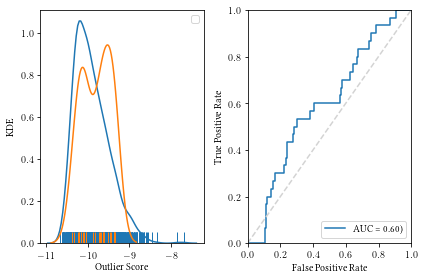

In [11]:
dist = predictions
labels = is_outlier.any(axis=-1)

print(labels)

plt.subplot(121)

# ugly but working
io = []
nio = []
for i, row in enumerate(dist):
    for j, val in enumerate(row):
        if labels[i][j]:
            nio.append([j, val])
        else:
            io.append([j, val])
io = pd.DataFrame(io)
nio = pd.DataFrame(nio)

# sns.scatterplot(io[0], io[1], label="ok")
sns.distplot(io[1], hist=False, rug=True)
sns.distplot(nio[1], hist=False, rug=True)
# sns.scatterplot(nio[0], nio[1], label="outlier", color="orange", alpha=0.7)
plt.xlabel("Outlier Score")
plt.ylabel("KDE")

plt.legend()

plt.subplot(122)

fpr, tpr, thresholds = roc_curve(labels.flatten(), dist.flatten())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='AUC = %0.2f)' % roc_auc)
plt.xlim((0,1))
plt.ylim((0,1))
plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('ROC Autoencoder 100-80-100 ReLU/Sigmoid synth\_multidim\_100\_000')
plt.legend(loc="lower right")

plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "figures", "results", "fedstream_{}.pdf".format(outlier_type)))